In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import os

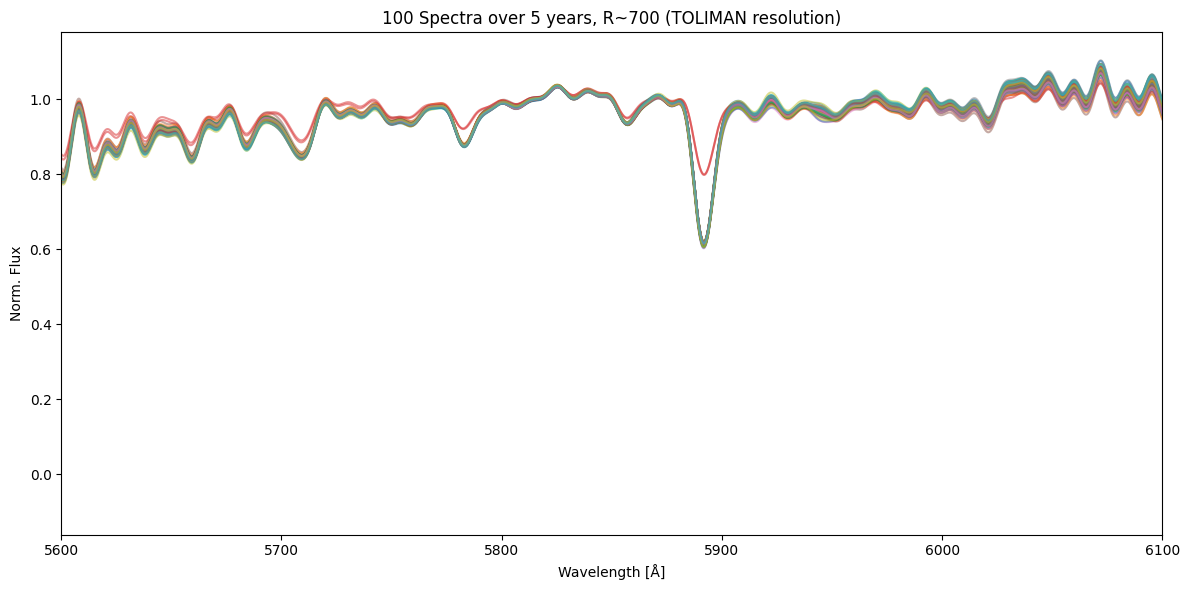

In [2]:
# --- Parameters ---
folder = "harps_sample"
max_files = 100  # Set your desired limit
P = 304e-6       # meters
D = 0.125        # meters
lambda0 = 640e-9 # meters

# Convert to angstroms for consistency with wavelength array
P_A = P * 1e10
D_A = D * 1e10
lambda0_A = lambda0 * 1e10
f_cutoff = (np.sqrt(2) / P_A) * (D_A / lambda0_A)  # in 1 / Å

# --- Plot setup ---
plt.figure(figsize=(12, 6))
plotted = 0

# Loop over all .fits files in the folder
for filename in os.listdir(folder):
    if not filename.endswith(".fits"):
        continue
    if plotted >= max_files:
        break

    filepath = os.path.join(folder, filename)
    try:
        hdul = fits.open(filepath)
        data = hdul[1].data[0]  # Extension 1, first row of table
        wavelength = data['WAVE']
        flux = data['FLUX']

        # Define normalization window (in Å)
        # Perhaps do this after filtering.. but not sure
        # Nope, looks best to do this before filtering!!
        norm_min = 5600
        norm_max = 6100

        # Get mask for values within the range
        norm_mask = (wavelength >= norm_min) & (wavelength <= norm_max)

        # Prevent divide-by-zero if no values are in range
        if np.sum(norm_mask) < 10:
            print(f"Skipping {filename}: not enough points in normalization window.")
            continue

        # Compute median in range and normalize
        median_flux = np.median(flux[norm_mask])
        flux = flux / median_flux
        # Check for uniform spacing
        dw = np.diff(wavelength)
        if not np.allclose(dw, dw[0], rtol=1e-4):
            print(f"Skipping {filename}: wavelength grid not uniform.")
            continue

        # FFT and filtering
        flux_fft = np.fft.fft(flux)
        freqs = np.fft.fftfreq(len(flux), d=dw[0])
        mask = np.abs(freqs) > f_cutoff
        flux_fft[mask] = 0
        flux_filtered = np.fft.ifft(flux_fft).real

        # Plot the filtered spectrum
        # Get the observation date
        obs_date = hdul[0].header.get('DATE-OBS', 'Unknown')
        plt.plot(wavelength, flux_filtered, alpha=0.5, label=obs_date)

        plotted += 1

    except Exception as e:
        print(f"Error processing {filename}: {e}")
        continue

# --- Finalize plot ---
plt.xlabel("Wavelength [Å]")
plt.ylabel("Norm. Flux")
plt.title(f"100 Spectra over 5 years, R~700 (TOLIMAN resolution)")
#plt.legend(fontsize='small', loc='lower right')
plt.xlim(5600,6100)
plt.tight_layout()
#plt.savefig('somespectra.png',dpi=300,bbox_inches='tight')
plt.show()

In [34]:
# Calculating correlation time:
# --- Parameters ---
folder = "harps_sample"
max_files = 110  # Set your desired limit
P = 304e-6       # meters
D = 0.125        # meters
lambda0 = 640e-9 # meters

# Convert to angstroms for consistency with wavelength array
P_A = P * 1e10
D_A = D * 1e10
lambda0_A = lambda0 * 1e10
f_cutoff = (np.sqrt(2) / P_A) * (D_A / lambda0_A)  # in 1 / Å

plotted = 0
spectra = []
dates = []
wavelengths = []

# Loop over all .fits files in the folder
for filename in os.listdir(folder):
    if not filename.endswith(".fits"):
        continue
    if plotted >= max_files:
        break

    filepath = os.path.join(folder, filename)
    try:
        hdul = fits.open(filepath)
        data = hdul[1].data[0]  # Extension 1, first row of table
        wavelength = data['WAVE']
        flux = data['FLUX']

        # Define normalization window (in Å)
        # Perhaps do this after filtering.. but not sure
        # Nope, looks best to do this before filtering!!
        norm_min = 5600
        norm_max = 6100

        # Get mask for values within the range
        norm_mask = (wavelength >= norm_min) & (wavelength <= norm_max)

        # Prevent divide-by-zero if no values are in range
        if np.sum(norm_mask) < 10:
            print(f"Skipping {filename}: not enough points in normalization window.")
            continue

        # Compute median in range and normalize
        median_flux = np.median(flux[norm_mask])
        flux = flux / median_flux
        # Check for uniform spacing
        dw = np.diff(wavelength)
        if not np.allclose(dw, dw[0], rtol=1e-4):
            print(f"Skipping {filename}: wavelength grid not uniform.")
            continue

        # FFT and filtering
        flux_fft = np.fft.fft(flux)
        freqs = np.fft.fftfreq(len(flux), d=dw[0])
        mask = np.abs(freqs) > f_cutoff
        flux_fft[mask] = 0
        flux_filtered = np.fft.ifft(flux_fft).real
        obs_date = hdul[0].header.get('DATE-OBS', 'Unknown')


        wavelengths.append(wavelength[norm_mask])
        spectra.append(flux_filtered[norm_mask])
        dates.append(obs_date)
        plotted += 1

    except Exception as e:
        print(f"Error processing {filename}: {e}")
        continue

In [ ]:
# stack into shape (n_arrays, 50001) and average over the first dimension
mean_spectrum = np.stack(spectra, axis=0).mean(axis=0)

# 2) normalize each array around the mean
norm_spectra = []
for a in spectra:
    d = a - mean_spectrum
    n = np.linalg.norm(d)
    if n == 0:
        # all elements equal to the mean → produce a zero‐array (or handle as you wish)
        norm_spectra.append(np.zeros_like(d))
    else:
        norm_spectra.append(d / n)

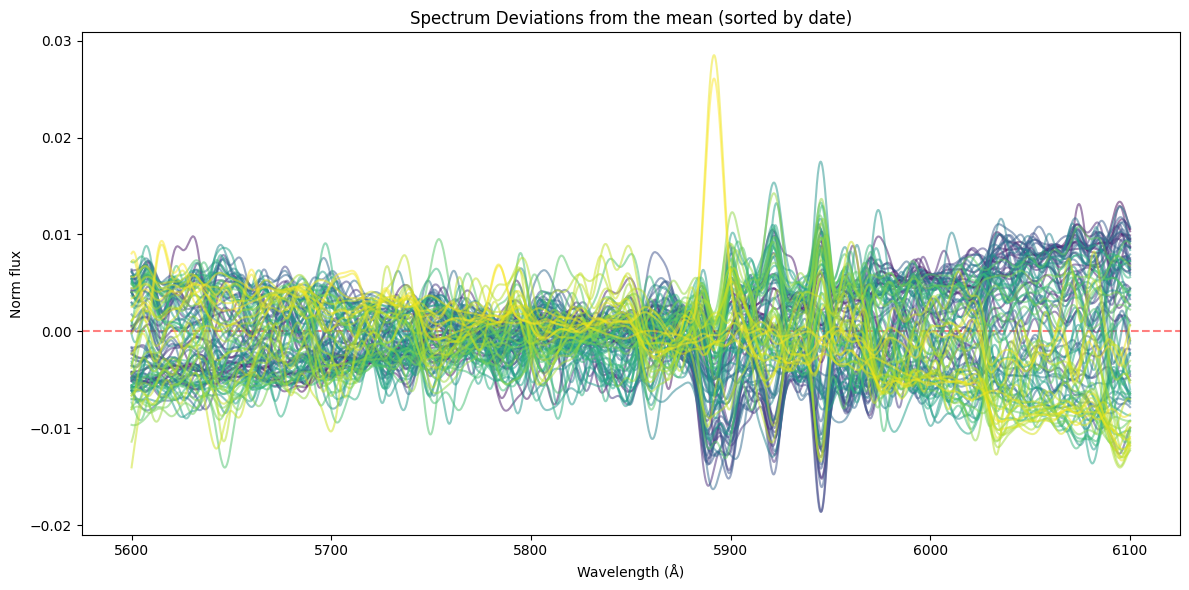

In [ ]:
import datetime
import matplotlib.pyplot as plt
import numpy as np

# 1) Parse your ISO timestamps into datetime objects
dates_dt = [datetime.datetime.fromisoformat(d) for d in dates]

# 2) Get the indices that would sort your dates in ascending order
sorted_idx = sorted(range(len(dates_dt)), key=lambda i: dates_dt[i])

# 3) Reorder your lists
dates_sorted      = [dates_dt[i]        for i in sorted_idx]
wavelengths_sorted= [wavelengths[i]     for i in sorted_idx]
spectra_sorted    = [norm_spectra[i]    for i in sorted_idx]

# 4) (Optional) for nicer color mapping
N = len(spectra_sorted)
colors = plt.cm.viridis(np.linspace(0,1,N))

# 5) Plot
plt.figure(figsize=(12,6))
plt.axhline(0, color='red', linestyle='--', alpha=0.5)

for spec, wave, col in zip(spectra_sorted, wavelengths_sorted, colors):
    plt.plot(wave, spec, alpha=0.5, color=col)

plt.title('Spectrum Deviations from the mean (sorted by date)')
plt.ylabel('Norm flux')
plt.xlabel('Wavelength (Å)')
plt.tight_layout()
plt.show()

# just from chatgpt


In [117]:
# 1) Stack your normalized spectra into an (N, L) array
norm_arr = np.stack(norm_spectra, axis=0)   # shape (N, L)
N = norm_arr.shape[0]

# 2) Parse your dates into numpy datetime64 (ms precision)
dates_np = np.array(dates, dtype='datetime64[ms]')  # shape (N,)

# 3) Prepare lists for Δt and C
dt_list   = []
corr_list = []

# 4) Loop over i<j (or vectorize if you like)
for i in range(N):
    for j in range(i+1, N):
        # Pearson‐style correlation = dot of two unit‐vectors
        Cij = np.dot(norm_arr[i], norm_arr[j])
        # time lag in days (float)
        dt  = np.abs(dates_np[j] - dates_np[i]) / np.timedelta64(1, 'D')
        dt_list.append(dt)
        corr_list.append(Cij)

dt_arr   = np.array(dt_list)
corr_arr = np.array(corr_list)

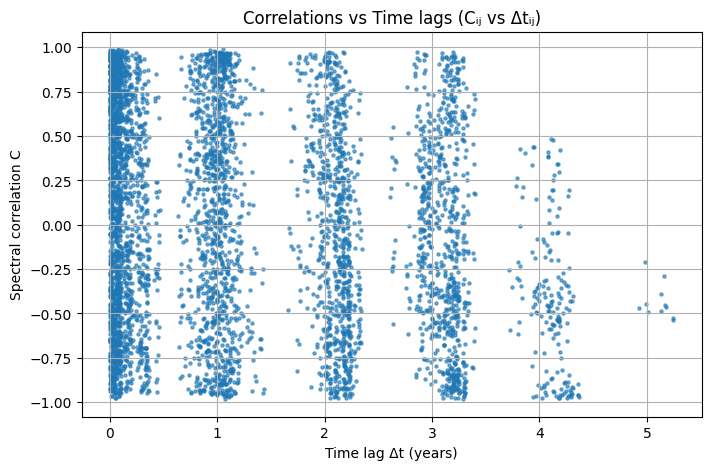

In [118]:
# 5) Make the scatter plot
plt.figure(figsize=(8,5))
plt.scatter(dt_arr/365.25, corr_arr, s=5, alpha=0.6)
plt.xlabel('Time lag Δt (years)')
plt.ylabel('Spectral correlation C')
plt.title('Correlations vs Time lags (Cᵢⱼ vs Δtᵢⱼ)')
plt.grid(True)
plt.show()

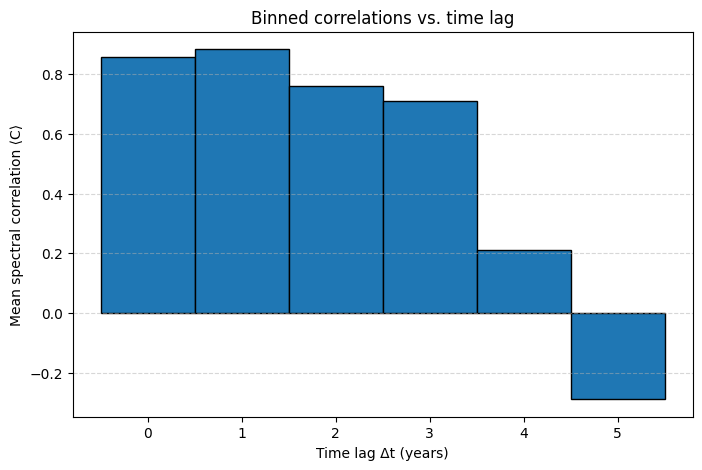

In [121]:
import numpy as np
import matplotlib.pyplot as plt

# assume dt_arr and corr_arr are your original arrays
# convert time‐lags to years:
dt_years = dt_arr / 365.25

# define bin edges at [-0.5, 0.5, 1.5, 2.5, ...] up to max(dt_years)
bin_edges = np.arange(-0.5, np.ceil(dt_years.max()) + 1, 1.0)

# digitize each dt into a bin index
bin_idx = np.digitize(dt_years, bin_edges)

# compute the bin centers for plotting
bin_centers = bin_edges[:-1] + 0.5

# compute mean correlation in each bin
means = []
for i in range(1, len(bin_edges)):
    sel = corr_arr[bin_idx == i]
    if len(sel) > 0:
        #means.append(sel.mean())
        means.append(np.percentile(sel,90))
    else:
        means.append(np.nan)   # or 0, or skip this bin

# now plot
plt.figure(figsize=(8,5))
plt.bar(bin_centers, means, width=1.0, align='center', edgecolor='k')
plt.xlabel('Time lag Δt (years)')
plt.ylabel('Mean spectral correlation ⟨C⟩')
plt.title('Binned correlations vs. time lag')
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.show()
